# Assessing genes for CRISPR screening

Using data from the DepMap portal, we can create some data visualizations to better represent potential genes of interest.

## Part 0: Data Preparation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's import our csv data for depmap, as well as the list for gene classifications:

In [199]:
depmap = pd.read_csv('datasets/depmap.csv', delimiter=',')

In [200]:
# swap the rows and columns for easier data access
depmap = depmap.transpose()

In [201]:
# set the column names to be the first row
depmap.columns = depmap.iloc[0]

In [202]:
# remove the first row
depmap.drop(depmap.index[[0]], inplace=True)

In [203]:
# remove numbers attached to the gene symbols
def format_index(table):
    gene_list = []
    for ind, row in table.iterrows():
        new_index = ind.split()
        gene_list.append(new_index[0])
    
    table.reset_index(inplace=True)
    table.insert(0, 'hgnc_symbol', gene_list)
    table.drop(labels=['index'], axis=1, inplace=True)

format_index(depmap)

In [204]:
# rename the first column
depmap.rename(index={'Unnamed: 0': 'index'}, inplace=True)

In [205]:
depmap

Unnamed: 0,hgnc_symbol,ACH-000164,ACH-000235,ACH-000243,ACH-000281,ACH-000320,ACH-000468,ACH-000601
0,A1BG,-0.0246236,0.178479,0.190157,0.128103,0.0801178,-0.183469,0.00744975
1,A1CF,0.0607031,0.123219,0.00916395,0.250814,0.209807,-0.111095,0.141809
2,A2M,-0.0951474,-0.0642431,0.023984,0.0349791,-0.26308,-0.0098931,-0.0293038
3,A2ML1,0.175003,0.157026,0.156006,0.133597,0.133151,0.0978103,0.244144
4,A3GALT2,-0.0969467,-0.0118657,-0.0730303,-0.0825586,-0.19652,0.0629397,-0.125533
...,...,...,...,...,...,...,...,...
16378,TOR3A,-0.0164497,-0.224793,-0.130085,0.0472863,-0.0769314,-0.0672694,-0.109366
16379,TOR4A,-0.0499945,0.0321407,-0.0322262,0.068559,-0.19677,-0.232897,-0.0791958
16380,TOX,-0.0587911,-0.0663157,-0.00981127,-0.0307534,0.0789109,0.130398,0.0223616
16381,TOX2,0.147551,0.184688,0.167271,0.190666,0.341036,0.278518,0.119335


In [10]:
def make_gene_group_dict(path):
    # importing the groups that these genes belong to
    group_df = pd.read_csv(path, delimiter=',')
    
    group_names = list(group_df.columns.values)
    
    group_numpy = group_df.to_numpy(copy=True)
    
    gene_group_dict = {}
    
    curr_group_name = ''
    for index, value in np.ndenumerate(group_numpy):
        curr_group_name = group_names[index[1]]
        gene_group_dict[value] = curr_group_name
    
    return gene_group_dict

gene_group_dict = make_gene_group_dict('datasets/partitioned-genes-list.csv')

In [11]:
def add_gene_groups(table):
    working_table = table.copy()
    # importing the groups that each of these genes belongs to
    working_table['Group'] = working_table['hgnc_symbol'].map(gene_group_dict).fillna('None')
    
    return working_table

# depmap groups has additional column with the group that each gene belongs to
depmap_groups = add_gene_groups(depmap)

In [78]:
depmap_groups

Unnamed: 0,hgnc_symbol,ACH-000164,ACH-000235,ACH-000243,ACH-000281,ACH-000320,ACH-000468,ACH-000601,Group
0,A1BG,-0.0246236,0.178479,0.190157,0.128103,0.0801178,-0.183469,0.00744975,None
1,A1CF,0.0607031,0.123219,0.00916395,0.250814,0.209807,-0.111095,0.141809,None
2,A2M,-0.0951474,-0.0642431,0.023984,0.0349791,-0.26308,-0.0098931,-0.0293038,None
3,A2ML1,0.175003,0.157026,0.156006,0.133597,0.133151,0.0978103,0.244144,None
4,A3GALT2,-0.0969467,-0.0118657,-0.0730303,-0.0825586,-0.19652,0.0629397,-0.125533,None
...,...,...,...,...,...,...,...,...,...
16378,TOR3A,-0.0164497,-0.224793,-0.130085,0.0472863,-0.0769314,-0.0672694,-0.109366,None
16379,TOR4A,-0.0499945,0.0321407,-0.0322262,0.068559,-0.19677,-0.232897,-0.0791958,None
16380,TOX,-0.0587911,-0.0663157,-0.00981127,-0.0307534,0.0789109,0.130398,0.0223616,None
16381,TOX2,0.147551,0.184688,0.167271,0.190666,0.341036,0.278518,0.119335,None


## Part 1: Scatter Plots for DepMap expression data

In [13]:
import seaborn as sns

In [80]:
def sort_by_increasing(table, cell_line):
    sorted_table = table.sort_values(cell_line)
    
    x_axis = []
    counter = 0
    for x in range(len(sorted_table)):
        x_axis.append(counter)
        counter = counter + 1
    
    sorted_table['Gene'] = x_axis
    
    return sorted_table

In [15]:
def draw_scatter_plot(table, cell_line, title, opacity):
    
    sorted_table = sort_by_increasing(table, cell_line)
    
    if opacity:
        sns.lmplot(x='Gene', y=cell_line, data=sorted_table, fit_reg=False, hue='Group', palette='bright', 
                   height=4, scatter_kws={'alpha':0.15, 's':60})
    else:
        sns.lmplot(x='Gene', y=cell_line, data=sorted_table, fit_reg=False, hue='Group', palette='bright',
                  scatter_kws={'s':10})
    
    for line in range(0,sorted_table.shape[0]):
        if sorted_table[cell_line][line] > 0.8:
            plt.text(sorted_table['Gene'][line]+0.01, sorted_table[cell_line][line]+0.01, 
            sorted_table['hgnc_symbol'][line], horizontalalignment='left', 
            fontsize=7, color='black')
    
    plt.title(title, fontsize=25, y=1.15)
    
    plt.ylabel('Expression Value')
    
    plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    
    # resizing the graph
    fig = plt.gcf()
    fig.set_size_inches(10, 10)

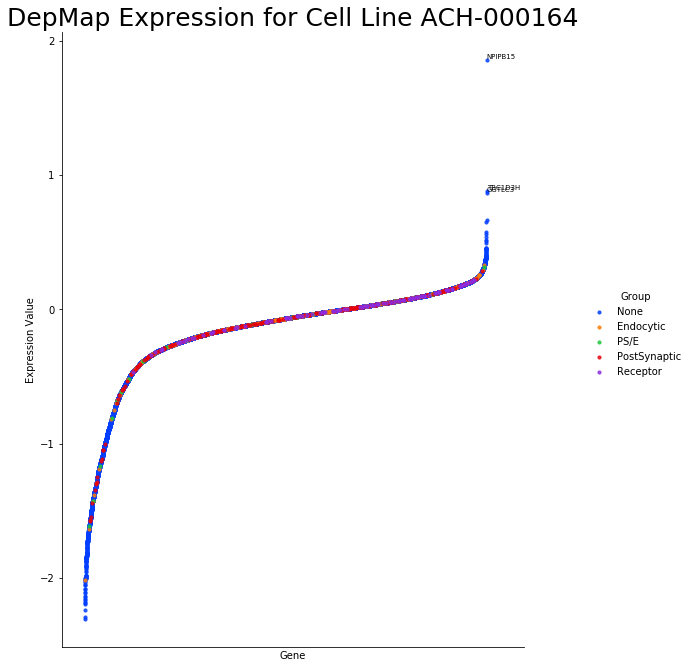

In [16]:
draw_scatter_plot(depmap_groups, 'ACH-000164', 'DepMap Expression for Cell Line ACH-000164', False)

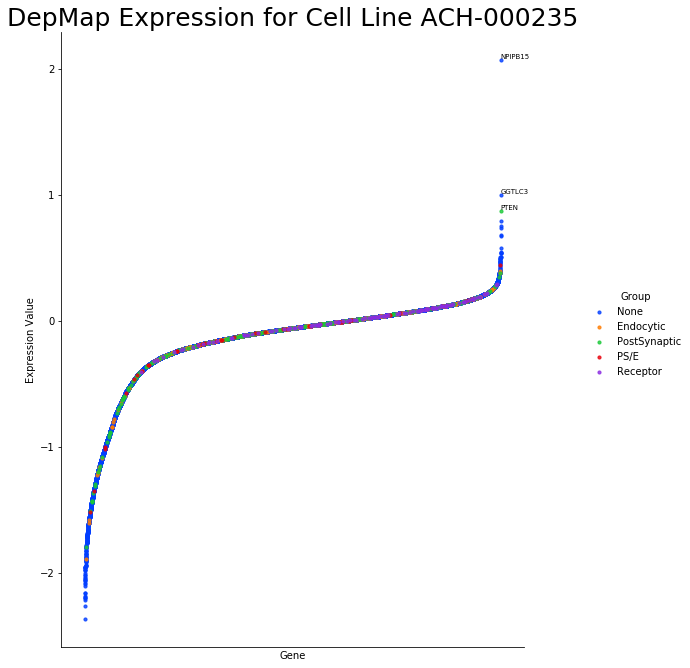

In [17]:
draw_scatter_plot(depmap_groups, 'ACH-000235', 'DepMap Expression for Cell Line ACH-000235', False)

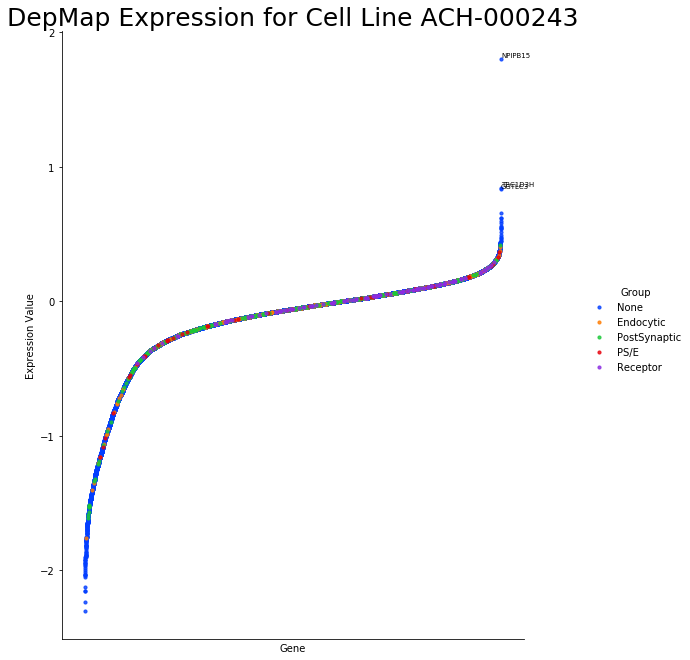

In [18]:
draw_scatter_plot(depmap_groups, 'ACH-000243', 'DepMap Expression for Cell Line ACH-000243', False)

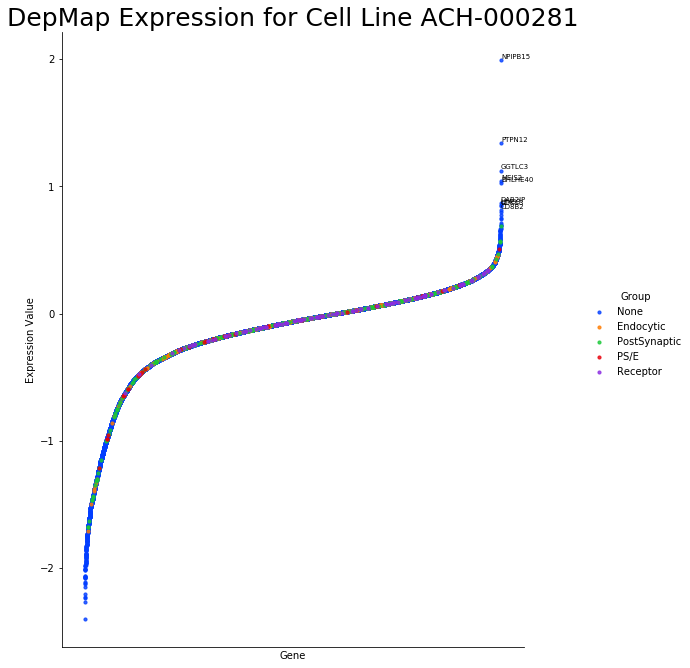

In [19]:
draw_scatter_plot(depmap_groups, 'ACH-000281', 'DepMap Expression for Cell Line ACH-000281', False)

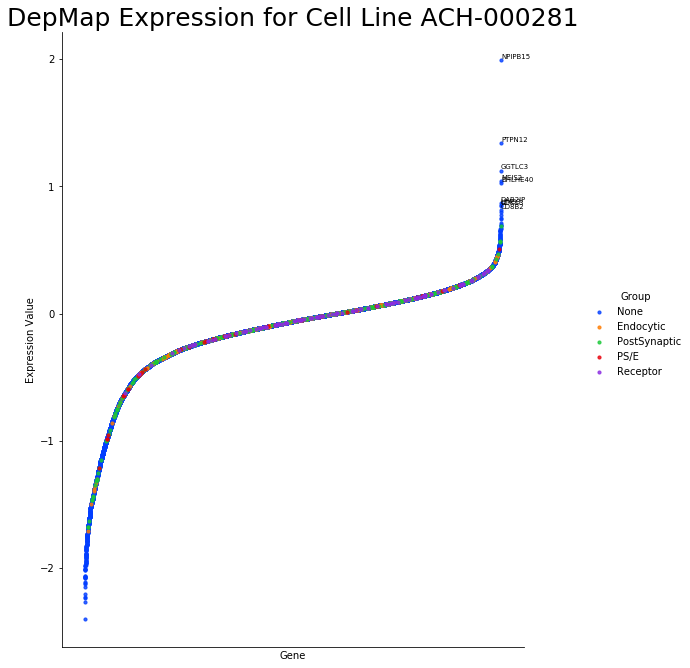

In [20]:
draw_scatter_plot(depmap_groups, 'ACH-000281', 'DepMap Expression for Cell Line ACH-000281', False)

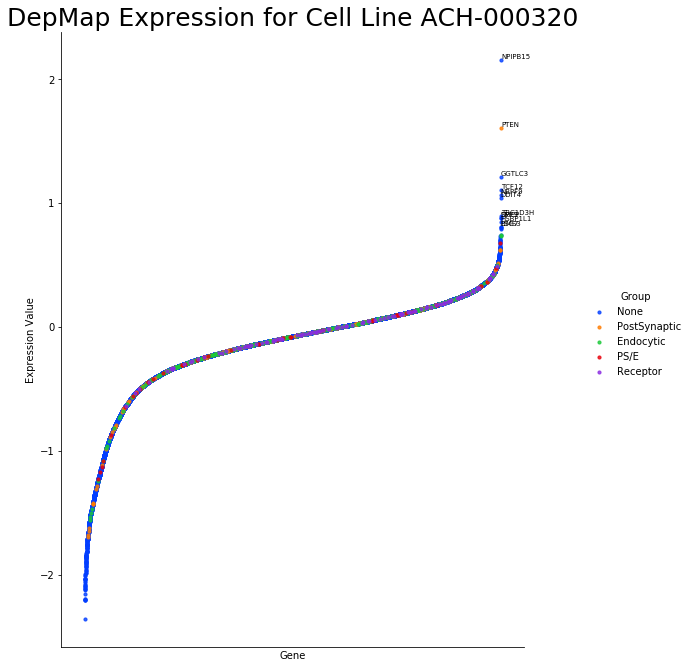

In [21]:
draw_scatter_plot(depmap_groups, 'ACH-000320', 'DepMap Expression for Cell Line ACH-000320', False)

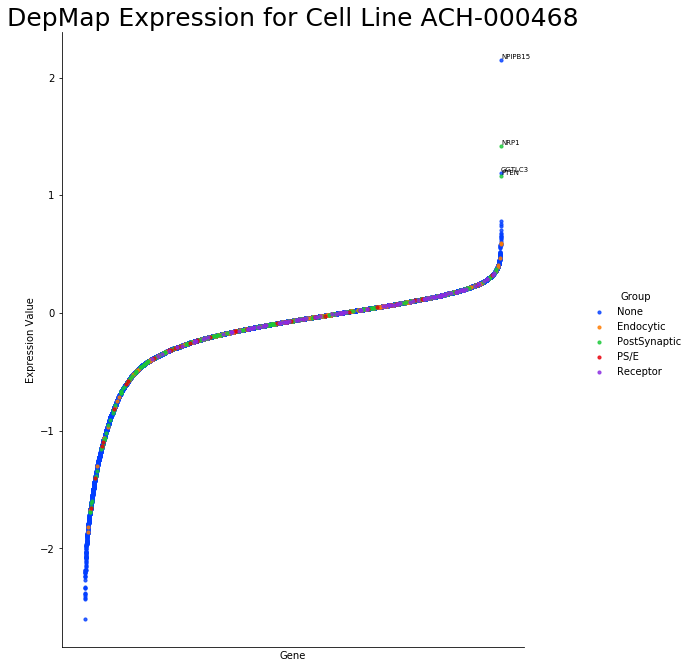

In [22]:
draw_scatter_plot(depmap_groups, 'ACH-000468', 'DepMap Expression for Cell Line ACH-000468', False)

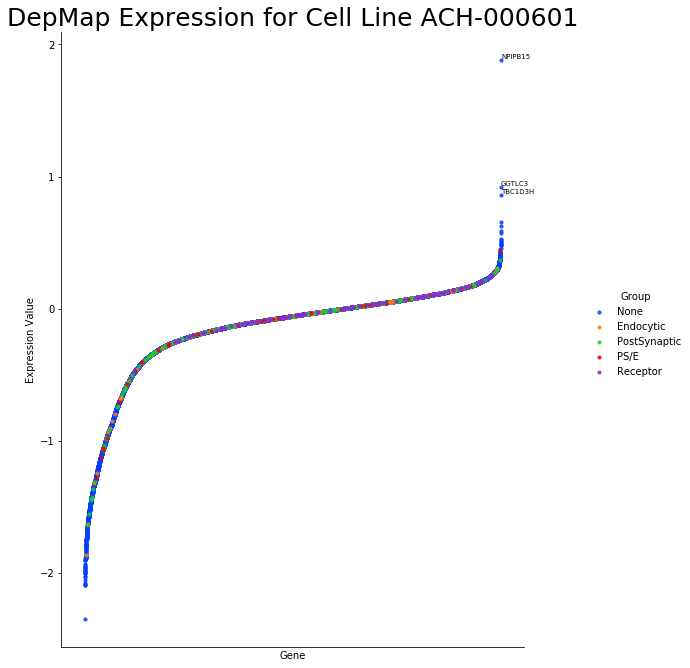

In [23]:
draw_scatter_plot(depmap_groups, 'ACH-000601', 'DepMap Expression for Cell Line ACH-000601', False)

### If we try changing the opacity of the graph, we get something like this:

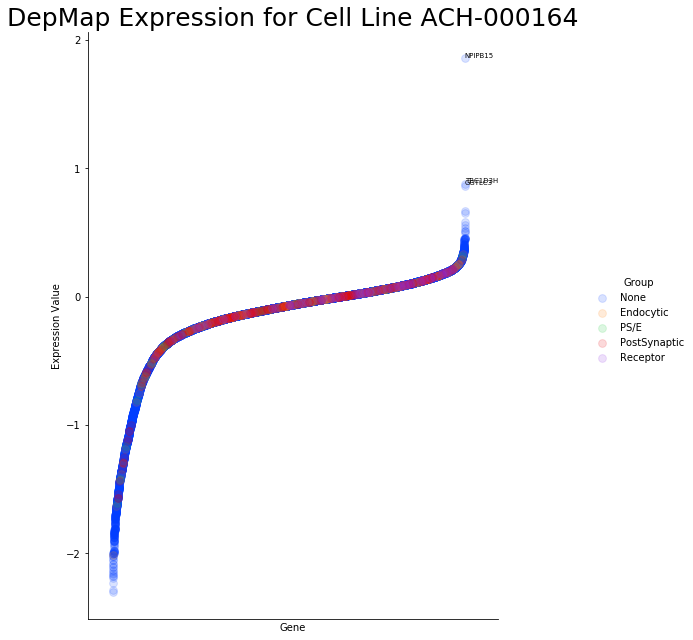

In [24]:
draw_scatter_plot(depmap_groups, 'ACH-000164', 'DepMap Expression for Cell Line ACH-000164', True)

average every post synaptic gene and t test comparison to all of the other genes added together

### Part 1.b Taking the average of the cell lines

the function average_cell_lines should take in the original depmap first and then add the necessary groups to the table for plotting.

In [25]:
def average_cell_lines(table):
    depmap = table.copy()
    
    hgnc_column = depmap['hgnc_symbol']
    depmap.drop(labels=['hgnc_symbol'], axis=1, inplace=True)
    
    depmap['Average'] = depmap.mean(axis=1)
    
    depmap.insert(0, 'hgnc_symbol', hgnc_column)
    
    return depmap

In [26]:
depmap_average = average_cell_lines(depmap)

In [29]:
depmap_average_groups = add_gene_groups(depmap_average)

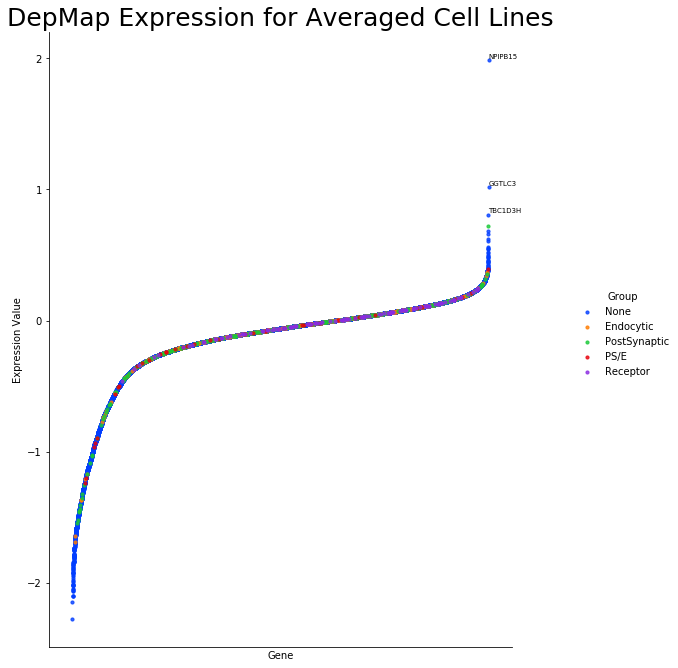

In [30]:
draw_scatter_plot(depmap_average_groups, 'Average', 'DepMap Expression for Averaged Cell Lines', False)

### Part 1.c Highlighting Specific Groups

We can highlight certain groups in our scatter plot to show where certain groups tend to fall.

In [172]:
def add_highlight_group(table, group):
    working_table = table.copy()
    
    highlight_dict = {}
    for gene in gene_group_dict:
        if gene_group_dict[gene] == group:
            highlight_dict[gene] = gene_group_dict[gene]
    
    # importing the groups that each of these genes belongs to
    working_table['Group'] = working_table['hgnc_symbol'].map(highlight_dict).fillna('Other')
    
    return working_table

# depmap ps has additional column with two groups, ps group and other
depmap_ps = add_highlight_group(depmap_average, 'PostSynaptic')

In [173]:
depmap_pse = add_highlight_group(depmap_average, 'PS/E')

In [174]:
depmap_e = add_highlight_group(depmap_average, 'Endocytic')

In [178]:
depmap_r = add_highlight_group(depmap_average, 'Receptor')

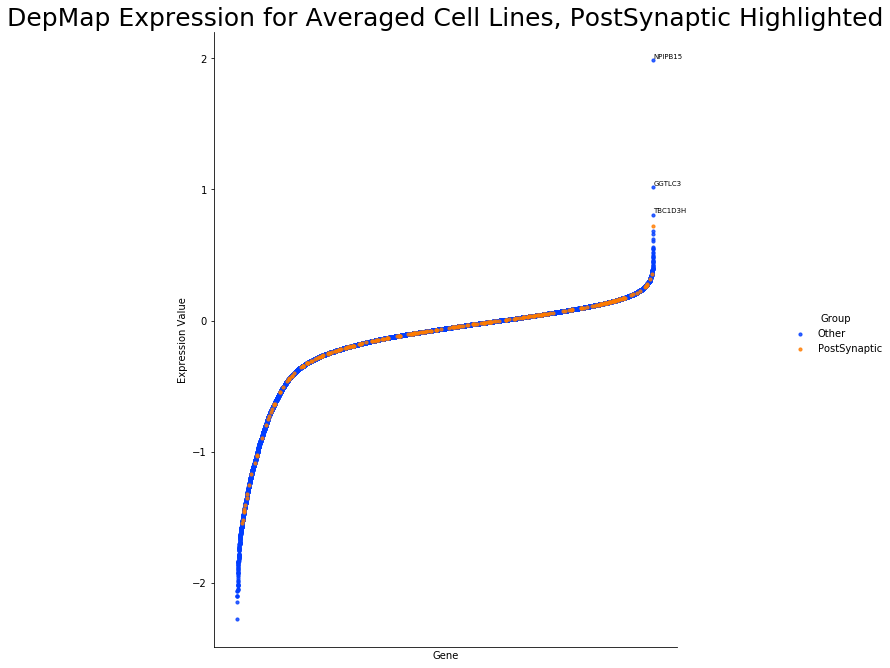

In [175]:
draw_scatter_plot(depmap_ps, 'Average', 'DepMap Expression for Averaged Cell Lines, PostSynaptic Highlighted', False)

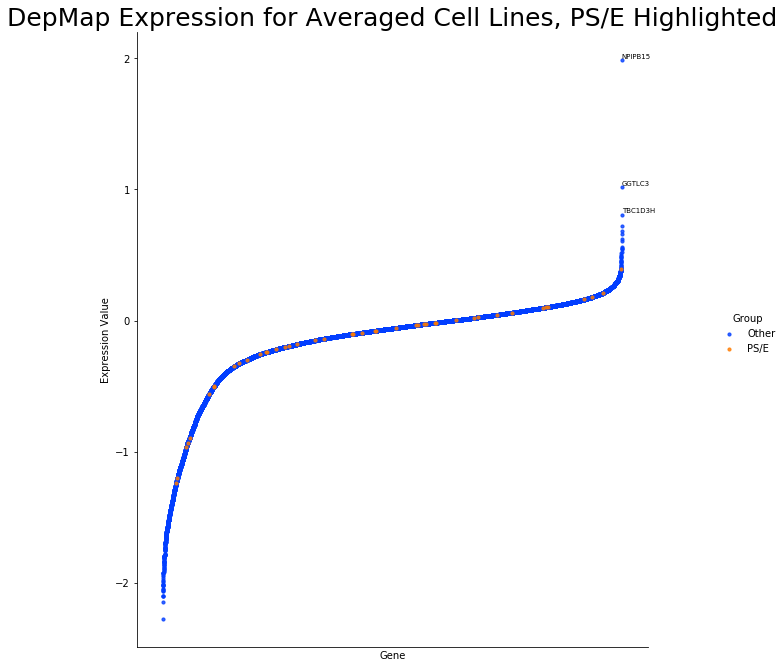

In [179]:
draw_scatter_plot(depmap_pse, 'Average', 'DepMap Expression for Averaged Cell Lines, PS/E Highlighted', False)

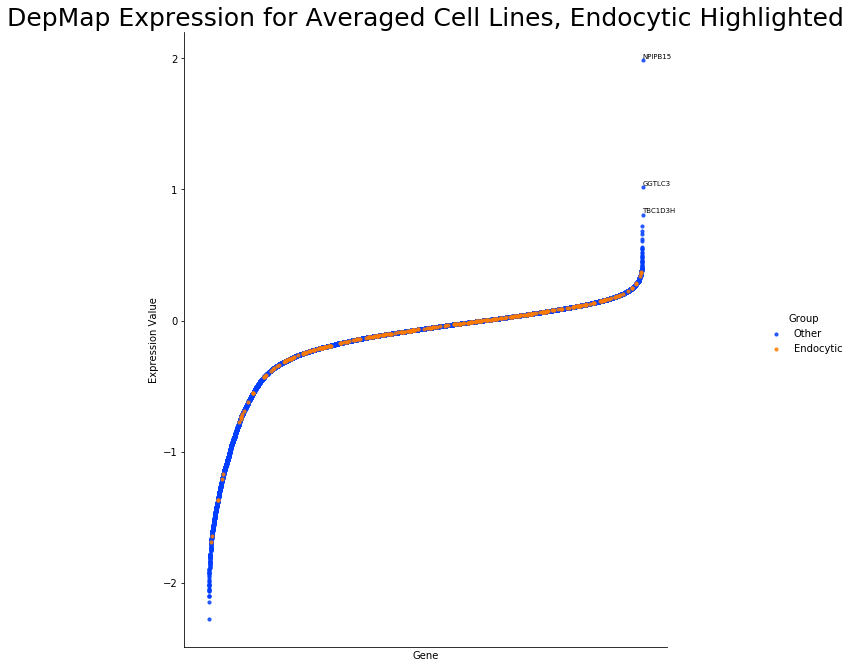

In [180]:
draw_scatter_plot(depmap_e, 'Average', 'DepMap Expression for Averaged Cell Lines, Endocytic Highlighted', False)

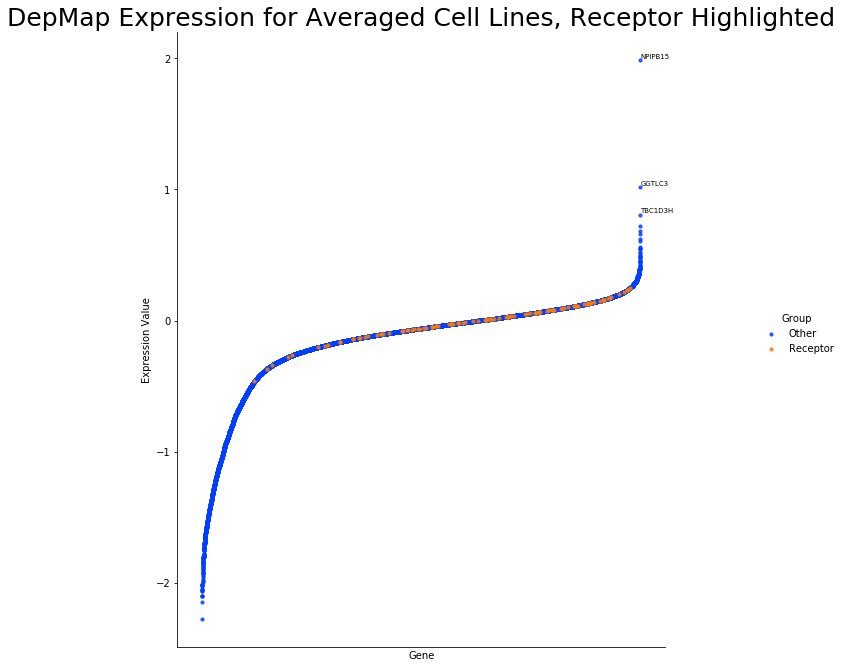

In [229]:
draw_scatter_plot(depmap_r, 'Average', 'DepMap Expression for Averaged Cell Lines, Receptor Highlighted', False)

# Part 2: T-testing for significance

We can perform t-tests for our three target groups.

In [40]:
from scipy import stats

In [81]:
def separate_sample_groups(table, group, cell_line):
    group_values = []
    non_group_values = []
    for ind, row in table.iterrows():
        gene = row['hgnc_symbol']
        if gene in gene_group_dict:
            if gene_group_dict[gene] == group: #if this gene is in your group of interest
                group_values.append(row[cell_line])
            elif gene_group_dict[gene] == 'PS/E': #count ps/e as part of ps and e
                if group == 'PostSynaptic' or group == 'Endocytic':
                    group_values.append(row[cell_line])
                else: #if group is not ps or e
                    non_group_values.append(row[cell_line])
            else: #if gene is not ps, e, or ps/e
                non_group_values.append(row[cell_line])
        else: #if it's not categorized in the dictionary
            non_group_values.append(row[cell_line])
            
    return group_values, non_group_values

In [82]:
def t_test_groups(table, group, cell_line):
    
    group_values, non_group_values = separate_sample_groups(table, group, cell_line)
    
    t, p = stats.ttest_ind(group_values, non_group_values, nan_policy='omit')
    
    return t, p
            

In [213]:
def t_test_table(table, table_average, group):
    cell_line_list = list(table.columns.values)[1:]
    cell_line_list.append('Average')
    
    t_table = []
    for line in cell_line_list:
        row = []
        if line == 'Average':
            t, p = t_test_groups(table_average, group, line)
        else:
            t, p = t_test_groups(table, group, line)
        row.append(t)
        row.append(p)
        t_table.append(row)
        
    t_test_df = pd.DataFrame(t_table, columns=['t-score', 'p-value'])
        
    t_test_df.insert(0, 'Cell Lines', cell_line_list)
    
    return t_test_df

### T-test values for PostSynaptic

Input: First argument is the table we are using, second is the group that we are performing the T-test on, and the third is the cell line we are using

Output: First value is t-score, second value is p-value



In [191]:
t_test_table(depmap, depmap_average, 'PostSynaptic')

,Cell Lines,t-score,p-value
0,ACH-000164,0.144660,0.884981
1,ACH-000235,-0.107585,0.914326
2,ACH-000243,0.418143,0.675848
3,ACH-000281,-0.886094,0.375580
4,ACH-000320,0.917739,0.358769
5,ACH-000468,-0.491272,0.623241
6,ACH-000601,0.239183,0.810967
7,Average,0.058735,0.953164


### T-test values for Endocytic

Input: First argument is the table we are using, second is the group that we are performing the T-test on, and the third is the cell line we are using

Output: First value is t-score, second value is p-value

In [192]:
t_test_table(depmap, depmap_average, 'Endocytic')

,Cell Lines,t-score,p-value
0,ACH-000164,1.755632,0.079171
1,ACH-000235,1.835780,0.066408
2,ACH-000243,2.675730,0.007464
3,ACH-000281,1.145512,0.252014
4,ACH-000320,2.185786,0.028845
5,ACH-000468,1.443078,0.149018
6,ACH-000601,2.158698,0.030888
7,Average,1.963132,0.049648


### T-test values for Receptor

Input: First argument is the table we are using, second is the group that we are performing the T-test on, and the third is the cell line we are using

Output: First value is t-score, second value is p-value

In [193]:
t_test_table(depmap, depmap_average, 'Receptor')

,Cell Lines,t-score,p-value
0,ACH-000164,4.314170,0.000016
1,ACH-000235,4.703376,0.000003
2,ACH-000243,4.828362,0.000001
3,ACH-000281,3.858718,0.000114
4,ACH-000320,4.319689,0.000016
5,ACH-000468,4.423851,0.000010
6,ACH-000601,4.208012,0.000026
7,Average,4.618497,0.000004


# Part 3: Using the Kolmogorov-Smirnov Test

We can try a different test to determine if two samples are different from one another without having to ensure that samples must be normally distributed. We're using the two-sided K-S test to test the null hypothesis: two independent samples are drawn from the same continuous distribution. 

The output, test statistic (also known as D) refers to the maximum difference between two cumulative distributions functions (your two samples).

The K-S test can be run with the scipy stats library.

"As Stijn pointed out, the k-s test returns a D statistic and a p-value corresponding to the D statistic. The D statistic is the absolute max distance (supremum) between the CDFs of the two samples. The closer this number is to 0 the more likely it is that the two samples were drawn from the same distribution...

The p-value returned by the k-s test has the same interpretation as other p-values. You reject the null hypothesis that the two samples were drawn from the same distribution if the p-value is less than your significance level. You can find tables online for the conversion of the D statistic into a p-value if you are interested in the procedure."
https://stats.stackexchange.com/questions/57885/how-to-interpret-p-value-of-kolmogorov-smirnov-test-python

In [208]:
def ks_test(table, group, cell_line):
    
    group_values, non_group_values = separate_sample_groups(table, group, cell_line)
    
    statistic, p_value = stats.ks_2samp(group_values, non_group_values)
    
    return statistic, p_value

In [214]:
def ks_test_table(table, table_average, group):
    cell_line_list = list(table.columns.values)[1:]
    cell_line_list.append('Average')
    
    ks_table = []
    for line in cell_line_list:
        row = []
        if line == 'Average':
            d, p = ks_test(table_average, group, line)
        else:
            d, p = ks_test(table, group, line)
        row.append(d)
        row.append(p)
        ks_table.append(row)
        
    ks_test_df = pd.DataFrame(ks_table, columns=['KS-statistic', 'p-value'])
        
    ks_test_df.insert(0, 'Cell Lines', cell_line_list)
    
    return ks_test_df

### K-S Statistic for PostSynaptic

Input: First argument is the table we are using, second is the group that we are performing the KS test on, and the third is the cell line we are using

Output: First value is KS Statistic D, second value is a two-tailed p-value



In [210]:
ks_test_table(depmap, depmap_average, 'PostSynaptic')

,Cell Lines,KS-statistic,p-value
0,ACH-000164,0.038446,0.798816
1,ACH-000235,0.046475,0.576324
2,ACH-000243,0.044072,0.643927
3,ACH-000281,0.039229,0.778363
4,ACH-000320,0.046027,0.588811
5,ACH-000468,0.055224,0.356132
6,ACH-000601,0.035487,0.869662
7,Average,0.030630,0.954030


### K-S Statistic for Endocytic

Input: First argument is the table we are using, second is the group that we are performing the KS test on, and the third is the cell line we are using

Output: First value is KS Statistic D, second value is a two-tailed p-value



In [211]:
ks_test_table(depmap, depmap_average, 'Endocytic')

,Cell Lines,KS-statistic,p-value
0,ACH-000164,0.060190,0.214463
1,ACH-000235,0.068850,0.107869
2,ACH-000243,0.066370,0.132591
3,ACH-000281,0.051142,0.396182
4,ACH-000320,0.063129,0.171657
5,ACH-000468,0.057466,0.261010
6,ACH-000601,0.068835,0.108001
7,Average,0.063904,0.161575


### K-S Statistic for Receptor

Input: First argument is the table we are using, second is the group that we are performing the KS test on, and the third is the cell line we are using

Output: First value is KS Statistic D, second value is a two-tailed p-value



In [212]:
ks_test_table(depmap, depmap_average, 'Receptor')

,Cell Lines,KS-statistic,p-value
0,ACH-000164,0.245785,3.697530e-06
1,ACH-000235,0.254449,1.434059e-06
2,ACH-000243,0.287606,2.824277e-08
3,ACH-000281,0.217178,6.679984e-05
4,ACH-000320,0.206363,1.817641e-04
5,ACH-000468,0.239051,7.546277e-06
6,ACH-000601,0.208310,1.523668e-04
7,Average,0.266843,3.494814e-07


# Part 4: Mann Whitney U Test

We can also use the Mann Whitney U Test to compare two groups of normally distributed data. 

The Mann Whitney U Test is more sensitive to changes in the median, compared to K-S test which focuses more on shape of distribution.

"The two samples are combined and rank ordered together. The strategy is to determine if the values from the two samples are randomly mixed in the rank ordering or if they are clustered at opposite ends when combined. A random rank order would mean that the two samples are not different, while a cluster of one sample values would indicate a difference between them."

— Page 58, Nonparametric Statistics for Non-Statisticians: A Step-by-Step Approach, 2009.


The Mann Whitney U Test can be run with the scipy stats library.

U Statistic:
    If U is close to 1, medians are very different
    If U is close to (number of samples in distribution 1 x number of samples in distribution 2) / 2, then the medians
    are very similar.
    
P-value:
    less than 0.05 --> reject null hypothesis.

In [112]:
def mwu_test(table, group, cell_line):
    
    group_values, non_group_values = separate_sample_groups(table, group, cell_line)
    
    statistic, p_value = stats.mannwhitneyu(group_values, non_group_values)
    
    return statistic, p_value

In [217]:
def mwu_test_table(table, table_average, group):
    cell_line_list = list(table.columns.values)[1:]
    cell_line_list.append('Average')
    
    mwu_table = []
    for line in cell_line_list:
        row = []
        if line == 'Average':
            u, p = mwu_test(table_average, group, line)
        else:
            u, p = mwu_test(table, group, line)
        row.append(u)
        row.append(p)
        mwu_table.append(row)
        
    mwu_test_df = pd.DataFrame(mwu_table, columns=['U-statistic', 'p-value'])
        
    mwu_test_df.insert(0, 'Cell Lines', cell_line_list)
    
    return mwu_test_df

### U Statistic for PostSynaptic

Input: First argument is the table we are using, second is the group that we are performing the Mann Whitney U test on, and the third is the cell line we are using

Output: First value is U Statistic, second value is a two-tailed p-value



In [218]:
mwu_test_table(depmap, depmap_average, 'PostSynaptic')

,Cell Lines,U-statistic,p-value
0,ACH-000164,2284937.0,0.377233
1,ACH-000235,2297459.0,0.438377
2,ACH-000243,2272174.0,0.317942
3,ACH-000281,2257933.0,0.256949
4,ACH-000320,2254752.0,0.244207
5,ACH-000468,2240737.0,0.192340
6,ACH-000601,2289136.0,0.397477
7,Average,2297311.0,0.437643


### U Statistic for Endocytic

Input: First argument is the table we are using, second is the group that we are performing the Mann Whitney U test on, and the third is the cell line we are using

Output: First value is U Statistic, second value is a two-tailed p-value



In [219]:
mwu_test_table(depmap, depmap_average, 'Endocytic')

,Cell Lines,U-statistic,p-value
0,ACH-000164,2518881.0,0.481014
1,ACH-000235,2437067.0,0.150728
2,ACH-000243,2337769.0,0.012884
3,ACH-000281,2519231.0,0.482695
4,ACH-000320,2396039.0,0.063302
5,ACH-000468,2511818.0,0.447213
6,ACH-000601,2417634.0,0.102497
7,Average,2452919.0,0.199802


### U Statistic for Receptor

Input: First argument is the table we are using, second is the group that we are performing the Mann Whitney U test on, and the third is the cell line we are using

Output: First value is U Statistic, second value is a two-tailed p-value



In [220]:
mwu_test_table(depmap, depmap_average, 'Receptor')

,Cell Lines,U-statistic,p-value
0,ACH-000164,650253.0,3.691508e-07
1,ACH-000235,624417.0,2.204728e-08
2,ACH-000243,617884.0,1.036691e-08
3,ACH-000281,716408.0,1.514355e-04
4,ACH-000320,678104.0,5.729339e-06
5,ACH-000468,665358.0,1.696552e-06
6,ACH-000601,688023.0,1.413326e-05
7,Average,633605.0,6.191111e-08


# Part 5: k-sample Anderson-Darling Test

(The regular Anderson-Darling test takes one sample and compares it against a specified distribution, Guassian by default)

The Anderson-Darling Test tests that the samples are drawn from the same population.

The A-D test returns the test statistic, a list of critical values, and the significance level at which the null hypothesis can be rejected.

In [140]:
def ad_test(table, group, cell_line):
    
    group_values, non_group_values = separate_sample_groups(table, group, cell_line)
    
    statistic, crit_values, sig_level = stats.anderson_ksamp([group_values, non_group_values])
    
    return statistic, crit_values, sig_level

In [225]:
def ad_test_table(table, table_average, group):
    cell_line_list = list(table.columns.values)[1:]
    cell_line_list.append('Average')
    
    ad_table = []
    for line in cell_line_list:
        row = []
        if line == 'Average':
            s, c, l = ad_test(table_average, group, line)
        else:
            s, c, l = ad_test(table, group, line)
        row.append(s)
        row.append(c)
        row.append(l)
        ad_table.append(row)
        
    ad_test_df = pd.DataFrame(ad_table, columns=['AD-statistic', 'Critical Values', 'Significance Level'])
        
    ad_test_df.insert(0, 'Cell Lines', cell_line_list)
    
    return ad_test_df

### A-D Statistic for PostSynaptic

Input: First argument is the table we are using, second is the group that we are performing the A-D test on, and the third is the cell line we are using

Output: First value is test statistic, second value is a list of critical values for these significance levels: [25%, 10%, 5%, 2.5%, 1%, 0.5%, 0.1%], and a significance level at which the null hypothesis can be rejected.



In [226]:
ad_test_table(depmap, depmap_average, 'PostSynaptic')

/Users/sophia2/spring2020/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: p-value floored: true value smaller than 0.001
  """
/Users/sophia2/spring2020/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: p-value capped: true value larger than 0.25
  """


,Cell Lines,AD-statistic,Critical Values,Significance Level
0,ACH-000164,8.231044,"[0.32500000000000007, 1.226, 1.960999999999999...",0.001
1,ACH-000235,-0.576273,"[0.32500000000000007, 1.226, 1.960999999999999...",0.250
2,ACH-000243,-0.657087,"[0.32500000000000007, 1.226, 1.960999999999999...",0.250
3,ACH-000281,-0.603044,"[0.32500000000000007, 1.226, 1.960999999999999...",0.250
4,ACH-000320,-0.092655,"[0.32500000000000007, 1.226, 1.960999999999999...",0.250
5,ACH-000468,-0.465080,"[0.32500000000000007, 1.226, 1.960999999999999...",0.250
6,ACH-000601,-1.001470,"[0.32500000000000007, 1.226, 1.960999999999999...",0.250
7,Average,-0.927126,"[0.32500000000000007, 1.226, 1.960999999999999...",0.250


### A-D Statistic for Endocytic

Input: First argument is the table we are using, second is the group that we are performing the A-D test on, and the third is the cell line we are using

Output: First value is test statistic, second value is a list of critical values for these significance levels: [25%, 10%, 5%, 2.5%, 1%, 0.5%, 0.1%], and a significance level at which the null hypothesis can be rejected.



In [227]:
ad_test_table(depmap, depmap_average, 'Endocytic')

/Users/sophia2/spring2020/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: p-value floored: true value smaller than 0.001
  """
/Users/sophia2/spring2020/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: p-value capped: true value larger than 0.25
  """


,Cell Lines,AD-statistic,Critical Values,Significance Level
0,ACH-000164,10.298634,"[0.32500000000000007, 1.226, 1.960999999999999...",0.001000
1,ACH-000235,0.797812,"[0.32500000000000007, 1.226, 1.960999999999999...",0.154037
2,ACH-000243,2.626991,"[0.32500000000000007, 1.226, 1.960999999999999...",0.027302
3,ACH-000281,0.293396,"[0.32500000000000007, 1.226, 1.960999999999999...",0.250000
4,ACH-000320,1.018642,"[0.32500000000000007, 1.226, 1.960999999999999...",0.124194
5,ACH-000468,1.195081,"[0.32500000000000007, 1.226, 1.960999999999999...",0.104696
6,ACH-000601,2.434652,"[0.32500000000000007, 1.226, 1.960999999999999...",0.032563
7,Average,1.038016,"[0.32500000000000007, 1.226, 1.960999999999999...",0.121880


### A-D Statistic for Receptor

Input: First argument is the table we are using, second is the group that we are performing the A-D test on, and the third is the cell line we are using

Output: First value is test statistic, second value is a list of critical values for these significance levels: [25%, 10%, 5%, 2.5%, 1%, 0.5%, 0.1%], and a significance level at which the null hypothesis can be rejected.



In [228]:
ad_test_table(depmap, depmap_average, 'Receptor')

/Users/sophia2/spring2020/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: p-value floored: true value smaller than 0.001
  """


,Cell Lines,AD-statistic,Critical Values,Significance Level
0,ACH-000164,24.442406,"[0.32500000000000007, 1.226, 1.960999999999999...",0.001
1,ACH-000235,19.132897,"[0.32500000000000007, 1.226, 1.960999999999999...",0.001
2,ACH-000243,20.687798,"[0.32500000000000007, 1.226, 1.960999999999999...",0.001
3,ACH-000281,9.982326,"[0.32500000000000007, 1.226, 1.960999999999999...",0.001
4,ACH-000320,11.882944,"[0.32500000000000007, 1.226, 1.960999999999999...",0.001
5,ACH-000468,14.296336,"[0.32500000000000007, 1.226, 1.960999999999999...",0.001
6,ACH-000601,11.818213,"[0.32500000000000007, 1.226, 1.960999999999999...",0.001
7,Average,18.540202,"[0.32500000000000007, 1.226, 1.960999999999999...",0.001


# Part 5: Filtering Scatter Plot Data

We can further analyze the scatter plot data from part 1, and take out the upper 10% and lower 10% of the depmap data.

In [282]:
def filter_depmap(table):
    
    to_sort = table.copy()
    hgnc = to_sort.loc[:, 'hgnc_symbol']
    to_sort.drop('hgnc_symbol', axis=1, inplace=True)
    # we will take the sum across all the cell lines
    to_sort.loc[:, 'sum'] = to_sort.sum(axis=1)
    # sort values
    sort = to_sort.sort_values('sum', ascending=False)
    
    # add hgnc back in and add groups in
    sort.insert(0, 'hgnc_symbol', hgnc)
    sort.drop('sum', axis=1, inplace=True)
    sort_with_groups = add_gene_groups(sort)
    
    # filter 'None' type out
    sort_filtered = sort_with_groups[~sort_with_groups['Group'].isin(['None'])]
    
    # find the 10% value
    percentile = int(len(sort_filtered.index) * 0.1)
    
    upper_10 = sort_filtered.head(percentile)
    lower_10 = sort_filtered.tail(percentile)
    
    return upper_10, lower_10
    #result = pd.concat([upper_10, lower_10])
    
    #return result
    
    

In [283]:
upper_10, lower_10 = filter_depmap(depmap)

In [321]:
def draw_stripplot(table, upper, title):
    cell_line_list = list(table.columns.values)
    cell_line_list.remove('hgnc_symbol')
    cell_line_list.remove('Group')
    
    if upper:
        df_upper = pd.melt(table, id_vars=['hgnc_symbol', 'Group'], value_vars=cell_line_list, var_name='Cell Line')
    else:
        df_lower = pd.melt(table, id_vars=['hgnc_symbol', 'Group'], value_vars=cell_line_list, var_name='Cell Line')
    
    fig, ax = plt.subplots()
    sns.despine(bottom=True, left=True)
    
    upper_colors = sns.color_palette("magma")
    lower_colors = sns.color_palette("cool")
    
    if upper:
        sns.stripplot(x='value', y='hgnc_symbol', hue='Group', data=df_upper, dodge=True, alpha=.25, zorder=1, palette=upper_colors)
    else:
        sns.stripplot(x='value', y='hgnc_symbol', hue='Group', data=df_lower, dodge=True, alpha=.25, zorder=1, palette=lower_colors)
    
    if upper:
        sns.pointplot(x='value', y='hgnc_symbol', hue='Group', data=df_upper, dodge=0.532, join=False, 
                  markers='d', scale=0.75, ci=None, palette=upper_colors)
    else:
        sns.pointplot(x='value', y='hgnc_symbol', hue='Group', data=df_lower, dodge=0.532, join=False, 
                  markers='d', scale=0.75, ci=None, palette=lower_colors)
    
    # legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[4:], labels[4:], title="Group",
          handletextpad=0, columnspacing=1,
          loc="lower right", ncol=3, frameon=True)
    
    plt.title(title, fontsize=25, y=1.05)
    plt.xlabel('DepMap Expression')
    plt.ylabel('Gene Name')
    
    # resizing the graph
    fig = plt.gcf()
    fig.set_size_inches(10, 16)

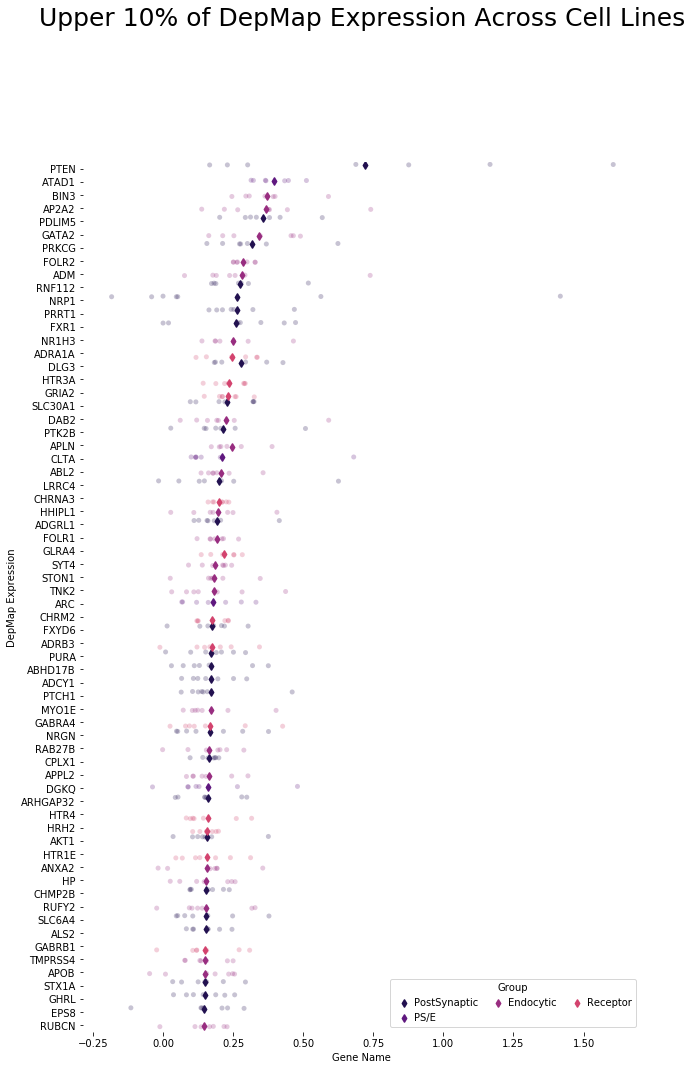

In [314]:
draw_stripplot(upper_10, True, 'Upper 10% of DepMap Expression Across Cell Lines')

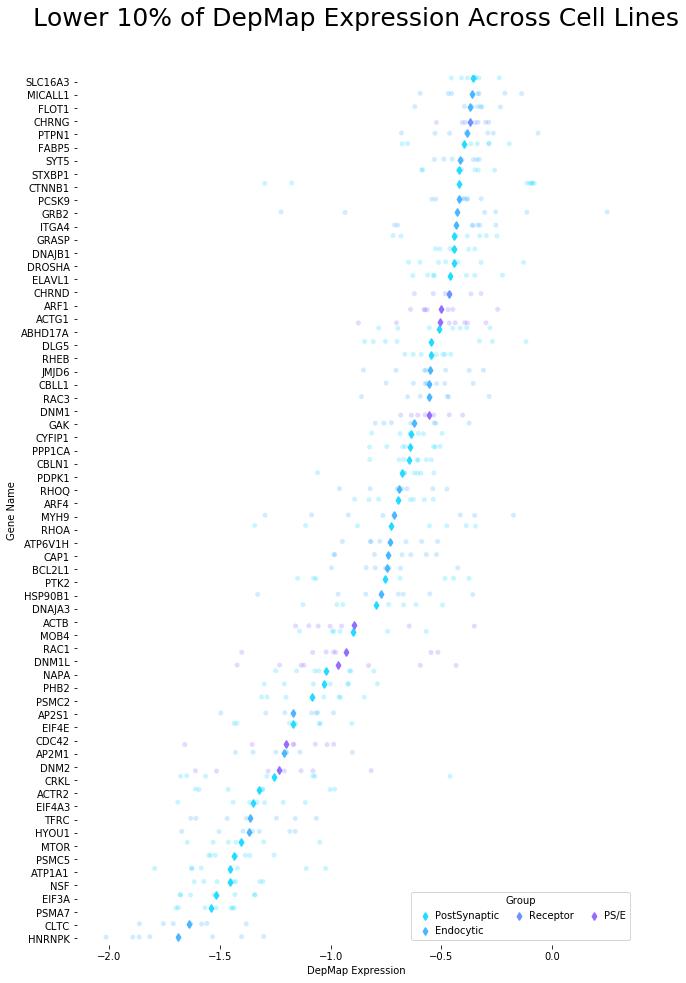

In [322]:
draw_stripplot(lower_10, False, 'Lower 10% of DepMap Expression Across Cell Lines')

# Part 6: Ridge Plots